In [1]:
import torch
import torch.nn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn, relu
from torchvision import datasets, transforms
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from time import time
from model import LinearVAE, NonLinearEncoderLinearDecoderVAE,DeepLinearEncoderLinearDecoderVAE,pPCA

In [2]:
class config:
    latent_dim = 200
    data_size = 1000
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

print(config.device)

def seed_torch(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)

cuda:0


In [3]:
seed_torch(0)
latent_dim = config.latent_dim
data_size = config.data_size
device = config.device

In [4]:
# preprocess
# ref[1] original paper Appendix E: Experiment details
#    [2] Papamakarios, G., Pavlakou, T., & Murray, I. (2017). 
#        Masked autoregressive flow for density estimation. 
#        Advances in neural information processing systems, 30.
mnist_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
]))
def preprocess(x, eps):
    x = (x + np.random.rand(*x.shape))/ 256.0
    x = eps + (1 - 2 * eps) * x
    x = np.log(x / (1.0 - x))
    x = x.to(torch.float32)
    return x


loader = mnist_data.data[:data_size].view(-1, 784)
loader = preprocess(loader,1e-6)
loader_numpy = loader.numpy()
loader = loader.to(device)

In [5]:

# Linear VAE
model = LinearVAE(784, latent_dim, 784, 1.0, True, mode='Stochastic').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
elbo_result = []

# Probability PCA
pcaModel = pPCA(loader_numpy, latent_dim)
W_mle, sigma_mle, loglikelihood = pcaModel.get_result()

# NonLinearEncoderLinearDecoderVAE
nonlinearencodermodel = NonLinearEncoderLinearDecoderVAE(784,latent_dim,784,1.0,True).to(device)
nonlinearOptimizer = optim.Adam(nonlinearencodermodel.parameters(), lr=0.0005)
nonlinear_elbo_result = []

# DeepLinearEncoderLinearDecoderVAE
deeplinearencodermodel = DeepLinearEncoderLinearDecoderVAE(784,latent_dim,784,1.0,True).to(device)
deeplinearOptimizer = optim.Adam(deeplinearencodermodel.parameters(), lr=0.0005)
deeplinear_elbo_result = []
start = time()
for i in range(50000):
    elbo = model(loader)
    elbo_nonlinear = nonlinearencodermodel(loader)[0]
    elbo_deeplinear = deeplinearencodermodel(loader)[0]
    
    optimizer.zero_grad()
    nonlinearOptimizer.zero_grad()
    deeplinearOptimizer.zero_grad()
    
    elbo_deeplinear.backward()
    elbo_nonlinear.backward()
    elbo.backward()
    
    optimizer.step()
    nonlinearOptimizer.step()
    deeplinearOptimizer.step()
    
    if i % 1000 == 0:
        elbo = elbo.detach().cpu().numpy()
        elbo_nonlinear = elbo_nonlinear.detach().cpu().numpy()
        elbo_deeplinear = elbo_deeplinear.detach().cpu().numpy()
        
        elbo_result.append(-elbo)
        nonlinear_elbo_result.append(-elbo_nonlinear)
        deeplinear_elbo_result.append(-elbo_deeplinear)
        print("Epoch:{}, exact loglikelihood:{}, LinearELBO:{},DeepLinearELBO:{},NonLinearELBO:{}".format(i, loglikelihood, -elbo,-elbo_deeplinear,-elbo_nonlinear))

Epoch:0, exact loglikelihood:-1277.9513758433404, LinearELBO:-16601.013671875,DeepLinearELBO:-195835.34375,NonLinearELBO:-7044.8583984375
Epoch:1000, exact loglikelihood:-1277.9513758433404, LinearELBO:-1903.8204345703125,DeepLinearELBO:-1720.744140625,NonLinearELBO:-1648.938720703125
Epoch:2000, exact loglikelihood:-1277.9513758433404, LinearELBO:-1721.8626708984375,DeepLinearELBO:-1606.01806640625,NonLinearELBO:-1556.087890625
Epoch:3000, exact loglikelihood:-1277.9513758433404, LinearELBO:-1638.663330078125,DeepLinearELBO:-1593.4674072265625,NonLinearELBO:-1489.1956787109375
Epoch:4000, exact loglikelihood:-1277.9513758433404, LinearELBO:-1580.0640869140625,DeepLinearELBO:-1525.9439697265625,NonLinearELBO:-1431.884765625
Epoch:5000, exact loglikelihood:-1277.9513758433404, LinearELBO:-1523.345703125,DeepLinearELBO:-1458.8385009765625,NonLinearELBO:-1394.53369140625
Epoch:6000, exact loglikelihood:-1277.9513758433404, LinearELBO:-1467.6949462890625,DeepLinearELBO:-1434.886962890625,N

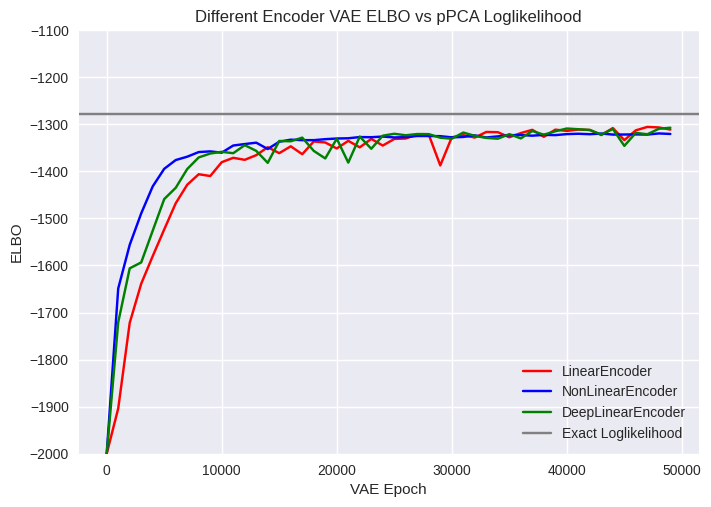

In [8]:
elbo_result_revised=np.array(elbo_result)
nonlinear_elbo_result_revised = np.array(nonlinear_elbo_result)
deeplinear_elbo_result_revised = np.array(deeplinear_elbo_result)
elbo_result_revised[elbo_result_revised<-2000]=-2000
nonlinear_elbo_result_revised[nonlinear_elbo_result_revised<-2000]=-2000
deeplinear_elbo_result_revised[deeplinear_elbo_result_revised<-2000]=-2000
plt.style.use("seaborn")
plt.plot(1000*np.arange(len(elbo_result_revised)),elbo_result_revised,label="LinearEncoder",color='red')
plt.plot(1000*np.arange(len(nonlinear_elbo_result_revised)),nonlinear_elbo_result_revised,label="NonLinearEncoder",color='blue')
plt.plot(1000*np.arange(len(deeplinear_elbo_result_revised)),deeplinear_elbo_result_revised,label="DeepLinearEncoder",color='green')
plt.axhline(y=loglikelihood,label="Exact Loglikelihood",color='grey')
plt.xlabel("VAE Epoch")
plt.ylabel("ELBO")
plt.ylim((-2000,-1100))
plt.legend(loc = "best")
plt.title("Different Encoder VAE ELBO vs pPCA Loglikelihood")
plt.savefig("Different_Encoder_VAE_ELBO_vs_pPCA_Loglikelihood.jpg",dpi=500)
plt.show()